# Click Through Rate Prediction
# Preliminary Research

# Introduction
The main goal of this workbook is to lay the foundation of the Propensity to Buy model that will be developed. The foundations laid here will lead to a model that is able to predict the CTR on a Google Ad so that I can later develope a mechanism to autogenerate optimized ad content.

Optimizing conversation rate on this advertisment pieces will then theorectically lead to improve revenue for the business. 

In this notebook basic Exploratory Data Analysis will be performed before moving onto the more advanced modelling and predictions. This is a preliminary notebook without prior knowledge of which techniques and models will and perform the best. 

First a Google Adwords connection needs to be established to gather the data. At first a download can be obtaned buy selecting the data required from the Google AdWords UI. This can later be changed to select the requried data programmatically. 

For most advertisers, the objective function to be maximized is the profit. For each keyword, we have:
profit = revenue - cost = (RPC - CPC) * clicks = (RPC - CPC) * impressions * CTR. 

As can be seen from this formula, both CTR and average CPC are important metrics that can determine the
performance of the advertiser’s SEO campaigns. Therefore, it is a crucial question on how to accurately predict the
CTR and average CPC on each keyword for the advertisers.

Since our goal is to predict the CTR or average CPC of a keyword, we cast it as a predictive modeling problem –
that is, to predict the CTR or average CPC given a set of features. However, it is not an easy task for the CTR and
average CPC prediction, since both are impacted by many features on Google Adwords. 

In general, all the features related to the keyword performance can be categorized into two types: contextual features
and historical features. The contextual features represent the current information regarding the context in which an
ad is shown, such as the device used by the users, the number of words used in the ad title and in the body of an ad,
the length of the URL, the individual words and terms used in the title and the body, etc. On the contrary, the
historical features depend on previous performance for the keyword or the ad, for example, the CTR, the average
CPC, the average position, etc, during a certain period in the near past. In aggregate, researchers found that those
historical features provide considerably more power than those contextual features for CTR prediction

First, let’s take a look at the features that have impacts on a keyword’s CTR. It is well known that the CTR of a
keyword decreases significantly when its average position gets lower. Since usually a higher bid for a keyword is
more likely to earn a higher position for this keyword on Google search result page, so the advertiser’s max CPC
definitely has an impact on the keyword’s CTR. The recent impressions, clicks, cost, average CPC, etc, all have
some exploratory power on the CTR prediction.

Match type also play an important role for the keyword performance. For example, for the same keyword, the broad
match usually attracts much higher traffic volume than the exact match, even with a much lower bid. Due to this
reason, it is not easy and fair to compare the performance between the different match types, therefore we will only
work on the search exact match types, as mentioned earlier.

It is obvious that all advertisers always continue to adjust the bid for their keywords, either raise or drop, in order to
improve the performance. For simplicity, in this date set, if the bid of the keyword was adjusted on that date, we only
use the max CPC before it was adjusted in that row. Also, the advertisers sometimes pause the keywords which
continuously have a bad performance, and for simplicity, we will only study the current enabled keywords in the
advertiser’s Google Adwords account

### Import Packages and Configuration

In [2]:
# Import necessary packages
import sys
from googleads import adwords
import os
from googleapiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

### Initializing Google Analytics Reporting API

In [7]:
# define key variables used in analysis
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'bhn-seo-tools-analytics-key.json')
VIEW_ID = '140617562'
DIMENSIONS = ['ga:source', 'ga:medium']
METRICS = ['ga:users', 'ga:sessions']

In [8]:
# create API connection
def initialize_analytics_reporting():
    """Initializes an Analytics Reporting API V4 service object.

    Returns:
    An authorized Analytics Reporting API V4 service object.
    """
    credentials = ServiceAccountCredentials.from_json_keyfile_name(
      KEY_FILE_LOCATION, SCOPES)

    # Build the service object.
    analytics = build('analyticsreporting', 'v4', credentials=credentials)

    return analytics

### Gather Data

In [9]:
# define report to return
def get_report(analytics):
    """Queries the Analytics Reporting API V4.
    https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/ for all metrics and dimensions

    Args:
    analytics: An authorized Analytics Reporting API V4 service object.
    Returns:
    The Analytics Reporting API V4 response.
    """
    return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': '7daysAgo', 'endDate': 'today'}],
            'metrics': [{'expression': i} for i in METRICS],
            'dimensions': [{'name': j} for j in DIMENSIONS]
        }]
      }
    ).execute()

# Data Pre-Processing

## Google Analytics Load Data

In [10]:
def convert_to_dataframe(response):
    for report in response.get('reports', []):
        column_header = report.get('columnHeader', {})
        dimension_headers = column_header.get('dimensions', [])
        metric_headers = [i.get('name', {}) for i in column_header.get('metricHeader', {}).get('metricHeaderEntries', [])]
        final_rows = []

        for row in report.get('data', {}).get('rows', []):
            dimensions = row.get('dimensions', [])
            metrics = row.get('metrics', [])[0].get('values', {})
            row_object = {}

            for header, dimension in zip(dimension_headers, dimensions):
                row_object[header] = dimension

            for metricHeader, metric in zip(metric_headers, metrics):
                row_object[metricHeader] = metric

            final_rows.append(row_object)

    data_frame_format = pd.DataFrame(final_rows)
    return data_frame_format

In [ ]:
# parse JSON response from API and print
# todo: change to pandas df
def print_response(response):
    """Parses and prints the Analytics Reporting API V4 response.

      Args:
        response: An Analytics Reporting API V4 response.
      """
      for report in response.get('reports', []):
        column_header = report.get('columnHeader', {})
        dimension_headers = column_header.get('dimensions', [])
        metric_headers = column_header.get('metricHeader', {}).get('metricHeaderEntries', [])

        for row in report.get('data', {}).get('rows', []):
            dimensions = row.get('dimensions', [])
            date_range_values = row.get('metrics', [])

            for header, dimension in zip(dimension_headers, dimensions):
                print(header + ': ' + dimension)

            for i, values in enumerate(date_range_values):
                print('Date range: ' + str(i))
            for metricHeader, value in zip(metric_headers, values.get('values')):
                print(metricHeader.get('name') + ': ' + value)

In [13]:
# run gatherer and print/df parse
def main():
    analytics = initialize_analytics_reporting()
    response = get_report(analytics)
    df = convert_to_dataframe(response)
    print(df)

if __name__ == '__main__':
    main()


                                        ga:source   ga:medium ga:users  \
0                                        (direct)      (none)    13605   
1                      10-Cycling-Myths-Uncovered      Social        7   
2      10-Things-cyclists-wish-drivers-understood  newsletter        1   
3    10-ways-to-encourage-people-to-cycle-to-work      social        1   
4                               10.100.1.66:15871    referral        1   
..                                            ...         ...      ...   
995                         www-csuk.grgcloud.net    referral        2   
996      www-cyclingweekly-com.cdn.ampproject.org    referral       13   
997        www-telegraph-co-uk.cdn.ampproject.org    referral        2   
998                              www1.emarsys.net    referral        8   
999                               www2.worc.ac.uk    referral        1   

    ga:sessions  
0         19818  
1             7  
2             1  
3             1  
4             1  
.. 

## Google AdWords Load Data

In [ ]:
def main(client):
    # Initialize appropriate service.
    report_downloader = client.GetReportDownloader(version='v201809')

    # Create report query.
    report_query = (adwords.ReportQueryBuilder()
                    .Select('CampaignId', 'AdGroupId', 'Id', 'Criteria',
                            'CriteriaType', 'FinalUrls', 'Impressions', 'Clicks',
                            'Cost')
                    .From('CRITERIA_PERFORMANCE_REPORT')
                    .Where('Status').In('ENABLED', 'PAUSED')
                    .During('LAST_7_DAYS')
                    .Build())

    # You can provide a file object to write the output to. For this
    # demonstration we use sys.stdout to write the report to the screen.
    report_downloader.DownloadReportWithAwql(
        report_query, 'CSV', sys.stdout, skip_report_header=False,
        skip_column_header=False, skip_report_summary=False,
        include_zero_impressions=True)


if __name__ == '__main__':
    # Initialize client object.
    adwords_client = adwords.AdWordsClient.LoadFromStorage(path='adwords_config.yaml')

    main(adwords_client)

In [4]:
# convert percentages string to float
def percentage_to_float(x):
    return float(x.strip('%'))/100

In [5]:
train_data = pd.read_csv('../data/raw/adwords_ad_group_hour.csv', 
                      sep='\t',
                      parse_dates=['Day'],
                      thousands=',',
                      converters={'CTR':percentage_to_float,
                                 'Conv. rate':percentage_to_float})

In [11]:
train_data.profile_report(style={'full_width':True})

In [6]:
# drop unneeded columns
train_data.drop(columns=['Ad group type', 'Avg. Cost', 'Currency'], inplace=True)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134675 entries, 0 to 134674
Data columns (total 17 columns):
Day              134675 non-null datetime64[ns]
Day of week      134675 non-null object
Hour of day      134675 non-null int64
Campaign         134675 non-null object
Ad group         134675 non-null object
Device           134675 non-null object
Avg. position    134675 non-null float64
Impressions      134675 non-null int64
Clicks           134675 non-null int64
CTR              134675 non-null float64
Cost             134675 non-null float64
Avg. CPC         134675 non-null float64
Cost / conv.     134675 non-null float64
Conversions      134675 non-null float64
Conv. value      134675 non-null float64
Value / conv.    134675 non-null float64
Conv. rate       134675 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(3), object(4)
memory usage: 17.5+ MB


In [8]:
# create binary classifier column 0/1 - target
train_data['click_target'] = np.where(train_data['Clicks'] > 0, 1, 0)

In [9]:
train_data.describe()

,Hour of day,Avg. position,Impressions,Clicks,CTR,Cost,Avg. CPC,Cost / conv.,Conversions,Conv. value,Value / conv.,Conv. rate,click_target
count,134675.000000,134675.000000,134675.000000,134675.000000,134675.000000,134675.000000,134675.000000,134675.000000,134675.000000,134675.000000,134675.000000,134675.000000,134675.000000
mean,11.715582,1.503711,3.294271,0.922614,0.289500,0.214484,0.120996,0.044905,0.027355,2.425729,2.422317,0.010780,0.426248
std,5.249420,0.705670,9.242726,2.026323,0.413829,0.460657,0.204726,1.060780,0.183672,20.001443,17.432131,0.089212,0.494533
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.000000,2.000000,3.000000,1.000000,0.500000,0.280000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,23.000000,7.000000,1325.000000,39.000000,3.000000,9.720000,2.300000,140.800000,7.000000,1695.000000,270.000000,5.000000,1.000000


# Exploratory Data Analysis


### Overall Click Through Numbers

0    0.573752
1    0.426248
Name: click_target, dtype: float64

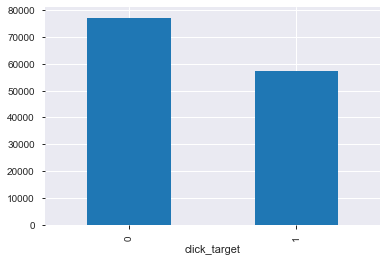

In [10]:
%matplotlib inline
train_data.groupby('click_target').size().plot(kind = 'bar')
rows = train_data.shape[0]

click_through_rate = train_data['click_target'].value_counts()/rows 

click_through_rate

### Clicks by Time of Day

In [11]:
train_data['Hour of day'].describe()

count    134675.000000
mean         11.715582
std           5.249420
min           0.000000
25%           8.000000
50%          12.000000
75%          15.000000
max          23.000000
Name: Hour of day, dtype: float64

In [14]:
df_impressions = train_data.groupby('Hour of day')['Clicks']
df_impressions
df_impressions.unstack().plot()

AttributeError: Cannot access callable attribute 'unstack' of 'SeriesGroupBy' objects, try using the 'apply' method

# Feature Relevance


# Feature Engineering


# Modelling


## Training


## Evaluation and Cross Validation


## Prediction


# Conclusion